In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools

In [3]:
# Define class name mapping
class_names = ['Mild', 'Moderate', 'Severe']

In [4]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:
# Dataset
dataset_dir = '/kaggle/input/acne-grading-classificationdataset/Created Dataset'
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=train_transform)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
val_dataset.dataset.transform = test_val_transform
test_dataset.dataset.transform = test_val_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

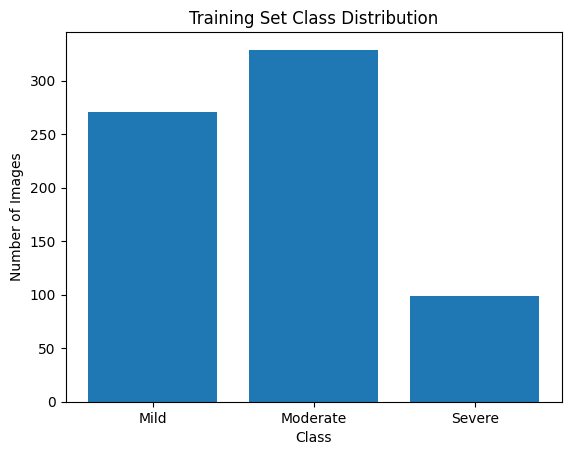

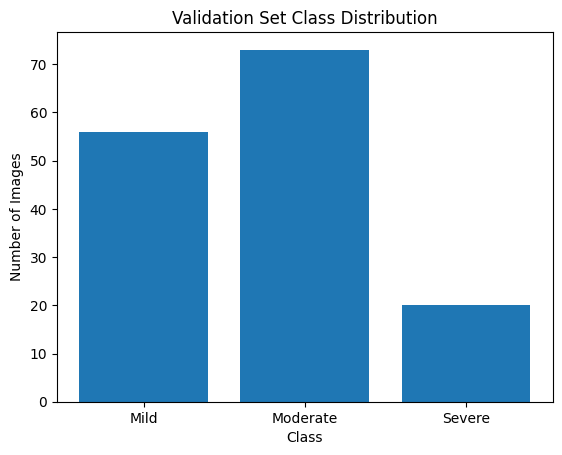

In [8]:
# Plot class distribution
def plot_class_distribution(dataset, title):
    class_counts = Counter(dataset.dataset.targets[i] for i in dataset.indices)
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(ticks=[0, 1, 2], labels=class_names)
    plt.show()

plot_class_distribution(train_dataset, "Training Set Class Distribution")
plot_class_distribution(val_dataset, "Validation Set Class Distribution")


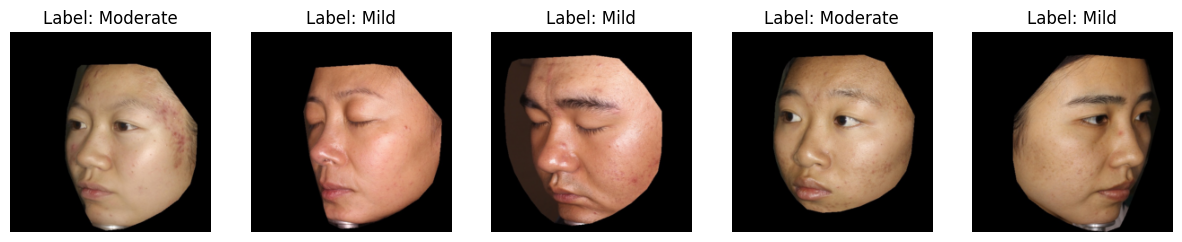

In [9]:
# Visualize samples
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
        image = np.clip(image, 0, 1)
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {class_names[label]}')
        axes[i].axis('off')
    plt.show()

visualize_samples(train_dataset)

In [10]:
# Function to evaluate on test
def evaluate_model(model, loader, dataset_type='Test'):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"\n{dataset_type} Accuracy: {accuracy:.4f}")
    print(f"{dataset_type} Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap=plt.cm.Blues)
    plt.title(f'{dataset_type} Confusion Matrix')
    plt.show()

    return accuracy, all_preds, all_labels

In [12]:
# Results tracking
results = []

# Train and Evaluate
def train_and_evaluate(model, train_loader, val_loader, optimizer_type='adam', lr=0.0003, num_epochs=15, model_name="Model"):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    class_counts = Counter([train_dataset.dataset.targets[i] for i in train_dataset.indices])
    class_weights = [1.0 / class_counts[i] for i in range(3)]
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

    optimizer = optim.Adam(model.parameters(), lr=lr) if optimizer_type == 'adam' else optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        scheduler.step()
        print(f"{model_name} | Epoch {epoch+1} | Loss: {running_loss/len(train_loader):.4f} | Accuracy: {correct/total:.4f}")

    # Evaluate on validation set
    model.eval()
    val_correct, val_total, all_preds, all_labels = 0, 0, [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = val_correct / val_total
    results.append((model_name, val_acc, all_preds, all_labels, model))

# Model list
num_classes = 3
optimizers = ['adam']
learning_rates = [0.001, 0.003, 0.0001]

model_variants = {
    'ResNet18': models.resnet18,
    'ResNet50': models.resnet50,
    'EfficientNet-B0': models.efficientnet_b0,
    'MobileNetV2': models.mobilenet_v2
}

# Run training
for model_name, model_fn in model_variants.items():
    for opt, lr in itertools.product(optimizers, learning_rates):
        model = model_fn(pretrained=True)
        if 'efficientnet' in model_name.lower():
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        elif 'mobilenet' in model_name.lower():
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        else:
            model.fc = nn.Linear(model.fc.in_features, num_classes)

        train_and_evaluate(model, train_loader, val_loader, optimizer_type=opt, lr=lr, model_name=f"{model_name} ({opt}, lr={lr})")

# Sort & print top models
results.sort(key=lambda x: x[1], reverse=True)
print("\nTop 3 Best Models:")
for name, acc, *_ in results[:3]:
    print(f"{name}: Validation Accuracy = {acc:.4f}")


ResNet18 (adam, lr=0.001) | Epoch 1 | Loss: 0.9299 | Accuracy: 0.5494
ResNet18 (adam, lr=0.001) | Epoch 2 | Loss: 0.5986 | Accuracy: 0.7010
ResNet18 (adam, lr=0.001) | Epoch 3 | Loss: 0.4793 | Accuracy: 0.7668
ResNet18 (adam, lr=0.001) | Epoch 4 | Loss: 0.4001 | Accuracy: 0.7940
ResNet18 (adam, lr=0.001) | Epoch 5 | Loss: 0.4231 | Accuracy: 0.8197
ResNet18 (adam, lr=0.001) | Epoch 6 | Loss: 0.3044 | Accuracy: 0.8512
ResNet18 (adam, lr=0.001) | Epoch 7 | Loss: 0.1759 | Accuracy: 0.9270
ResNet18 (adam, lr=0.001) | Epoch 8 | Loss: 0.1024 | Accuracy: 0.9614
ResNet18 (adam, lr=0.001) | Epoch 9 | Loss: 0.0800 | Accuracy: 0.9714
ResNet18 (adam, lr=0.001) | Epoch 10 | Loss: 0.0510 | Accuracy: 0.9886
ResNet18 (adam, lr=0.001) | Epoch 11 | Loss: 0.0232 | Accuracy: 0.9943
ResNet18 (adam, lr=0.001) | Epoch 12 | Loss: 0.0387 | Accuracy: 0.9914
ResNet18 (adam, lr=0.001) | Epoch 13 | Loss: 0.0144 | Accuracy: 0.9943
ResNet18 (adam, lr=0.001) | Epoch 14 | Loss: 0.0118 | Accuracy: 0.9957
ResNet18 (adam,

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s] 


ResNet50 (adam, lr=0.001) | Epoch 1 | Loss: 1.0869 | Accuracy: 0.4392
ResNet50 (adam, lr=0.001) | Epoch 2 | Loss: 0.7925 | Accuracy: 0.5765
ResNet50 (adam, lr=0.001) | Epoch 3 | Loss: 0.6560 | Accuracy: 0.6681
ResNet50 (adam, lr=0.001) | Epoch 4 | Loss: 0.5531 | Accuracy: 0.7225
ResNet50 (adam, lr=0.001) | Epoch 5 | Loss: 0.5350 | Accuracy: 0.7325
ResNet50 (adam, lr=0.001) | Epoch 6 | Loss: 0.4766 | Accuracy: 0.7554
ResNet50 (adam, lr=0.001) | Epoch 7 | Loss: 0.3088 | Accuracy: 0.8655
ResNet50 (adam, lr=0.001) | Epoch 8 | Loss: 0.1966 | Accuracy: 0.9213
ResNet50 (adam, lr=0.001) | Epoch 9 | Loss: 0.1925 | Accuracy: 0.9084
ResNet50 (adam, lr=0.001) | Epoch 10 | Loss: 0.1560 | Accuracy: 0.9328
ResNet50 (adam, lr=0.001) | Epoch 11 | Loss: 0.1603 | Accuracy: 0.9371
ResNet50 (adam, lr=0.001) | Epoch 12 | Loss: 0.0878 | Accuracy: 0.9728
ResNet50 (adam, lr=0.001) | Epoch 13 | Loss: 0.0572 | Accuracy: 0.9886
ResNet50 (adam, lr=0.001) | Epoch 14 | Loss: 0.0360 | Accuracy: 0.9928
ResNet50 (adam,

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 135MB/s] 


EfficientNet-B0 (adam, lr=0.001) | Epoch 1 | Loss: 0.7921 | Accuracy: 0.5751
EfficientNet-B0 (adam, lr=0.001) | Epoch 2 | Loss: 0.5610 | Accuracy: 0.7196
EfficientNet-B0 (adam, lr=0.001) | Epoch 3 | Loss: 0.4042 | Accuracy: 0.8069
EfficientNet-B0 (adam, lr=0.001) | Epoch 4 | Loss: 0.3941 | Accuracy: 0.8183
EfficientNet-B0 (adam, lr=0.001) | Epoch 5 | Loss: 0.3148 | Accuracy: 0.8627
EfficientNet-B0 (adam, lr=0.001) | Epoch 6 | Loss: 0.2188 | Accuracy: 0.9185
EfficientNet-B0 (adam, lr=0.001) | Epoch 7 | Loss: 0.0863 | Accuracy: 0.9685
EfficientNet-B0 (adam, lr=0.001) | Epoch 8 | Loss: 0.0743 | Accuracy: 0.9685
EfficientNet-B0 (adam, lr=0.001) | Epoch 9 | Loss: 0.1033 | Accuracy: 0.9571
EfficientNet-B0 (adam, lr=0.001) | Epoch 10 | Loss: 0.0767 | Accuracy: 0.9742
EfficientNet-B0 (adam, lr=0.001) | Epoch 11 | Loss: 0.0363 | Accuracy: 0.9871
EfficientNet-B0 (adam, lr=0.001) | Epoch 12 | Loss: 0.0252 | Accuracy: 0.9928
EfficientNet-B0 (adam, lr=0.001) | Epoch 13 | Loss: 0.0219 | Accuracy: 0.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 111MB/s] 


MobileNetV2 (adam, lr=0.001) | Epoch 1 | Loss: 0.8789 | Accuracy: 0.5637
MobileNetV2 (adam, lr=0.001) | Epoch 2 | Loss: 0.5199 | Accuracy: 0.7411
MobileNetV2 (adam, lr=0.001) | Epoch 3 | Loss: 0.4562 | Accuracy: 0.7840
MobileNetV2 (adam, lr=0.001) | Epoch 4 | Loss: 0.2650 | Accuracy: 0.8870
MobileNetV2 (adam, lr=0.001) | Epoch 5 | Loss: 0.2851 | Accuracy: 0.8813
MobileNetV2 (adam, lr=0.001) | Epoch 6 | Loss: 0.1980 | Accuracy: 0.9213
MobileNetV2 (adam, lr=0.001) | Epoch 7 | Loss: 0.1145 | Accuracy: 0.9528
MobileNetV2 (adam, lr=0.001) | Epoch 8 | Loss: 0.0607 | Accuracy: 0.9757
MobileNetV2 (adam, lr=0.001) | Epoch 9 | Loss: 0.0781 | Accuracy: 0.9642
MobileNetV2 (adam, lr=0.001) | Epoch 10 | Loss: 0.0514 | Accuracy: 0.9843
MobileNetV2 (adam, lr=0.001) | Epoch 11 | Loss: 0.0324 | Accuracy: 0.9900
MobileNetV2 (adam, lr=0.001) | Epoch 12 | Loss: 0.0529 | Accuracy: 0.9785
MobileNetV2 (adam, lr=0.001) | Epoch 13 | Loss: 0.0363 | Accuracy: 0.9871
MobileNetV2 (adam, lr=0.001) | Epoch 14 | Loss:

In [30]:
# Function to evaluate on test set
def evaluate_model(model, loader, dataset_type='Test'):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"\n{dataset_type} Accuracy: {accuracy:.4f}")
    print(f"{dataset_type} Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap=plt.cm.Blues)
    plt.title(f'{dataset_type} Confusion Matrix')
    plt.show()

    return accuracy, all_preds, all_labels


Best model saved: EfficientNet-B0 (adam, lr=0.001) with Validation Accuracy = 0.7919

Test Accuracy: 0.8543
Test Classification Report:
              precision    recall  f1-score   support

        Mild       0.86      0.92      0.89        60
    Moderate       0.88      0.80      0.84        71
      Severe       0.77      0.85      0.81        20

    accuracy                           0.85       151
   macro avg       0.84      0.86      0.84       151
weighted avg       0.86      0.85      0.85       151



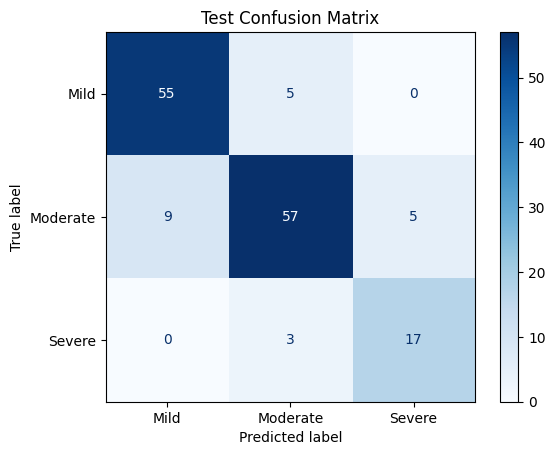

In [31]:
best_model = max(results, key=lambda x: x[1])  # Sorts by test_acc
best_model_name, best_val_acc, _, _, model_obj = best_model

# Save the best model
torch.save(model_obj, 'best_acne_classification_model.pt')
print(f"\nBest model saved: {best_model_name} with Validation Accuracy = {best_val_acc:.4f}")

# Evaluate on test set 
_ = evaluate_model(model_obj, test_loader, dataset_type="Test")